# <img style="float: left; padding-right: 10px; width: 45px"> GEC AI HUB: Introduction to Data Science and Machine Learning



## Lab 1: Classification and Dimensionality Reduction -- 

**GEC AI Hub**<br>
**Summer 2019**<br>
**Instructors:** Pavlos Protopapas<br>
**Lab Instructors:** Patrick Ohiomoba and Esteban Reyes<br>

---

In [34]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore different models used to predict which of several labels applies to a new datapoint based on labels observed in the training data. We'll similarly explore PCA as a technique for reducing the number of features in a dataset with as little loss of structure as possible.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Logistic Regression
- Be able to make an informed choice of model based on the data at hand
- Be familiar with the SKlearn implementation of Principle Components Analysis (PCA)
- Be able to select an appropriate number of PCA components
- (Bonus) Structure your sklearn code into Pipelines to make building, fitting, and tracking your models easier
- (Bonus) Apply weights to each class in the model to achieve your desired tradeoffs between discovery and false alarm in various classes

In [153]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from sklearn.linear_model import LinearRegression, LogisticRegression

from scipy.optimize import minimize

## Part 1:  Learning about Logistic Regression on Fake data

### Generating and Examining our Fake Data

We'll start by using some functionality within sklearn to generate fake labelled classification data in 1 dimension in order to get good intuition on why and how to use logistic regression for classification purposes in 1d.  For this purpose we'll be using the `make_classification` function in sklearn's datasets module.

In [30]:
fake_X, fake_y = make_classification(n_samples=200, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class=1, n_classes=2, flip_y=0.1, random_state=3423)

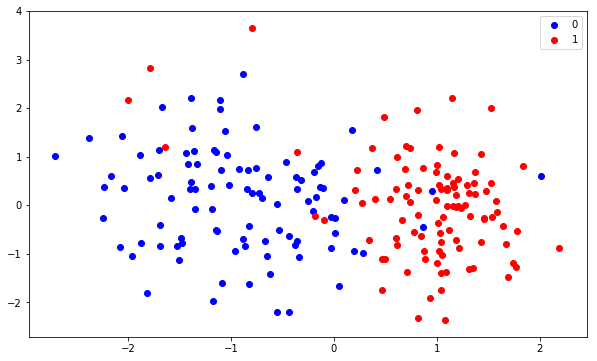

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_X[fake_y == 0][:, 1], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_X[fake_y == 1][:, 1], color='r', label='1')
plt.legend();

As you see, we have two clusters of labeled points: once cluster shwon in red labeled 0 and another cluster shown in blue labeled 1.  Each cluster consists of a set of points in a feature space corresponding to $\mathbb{R}^2$.  From casual inspection it looks like the points are somewhat well separated along the X-axis but not very well separated along the Y-axis.  Let's test this hypothesis.

Exercise: Visualize the separation of the points along each feature.  Show points for each class in different colors

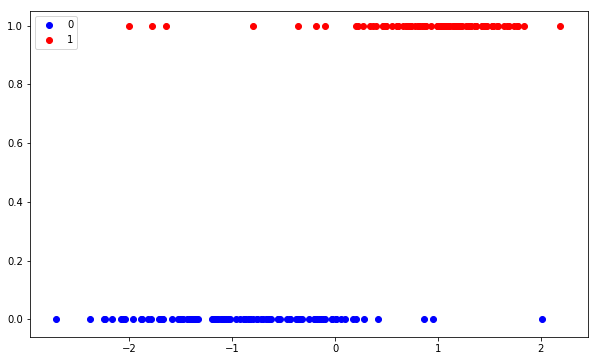

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.legend();

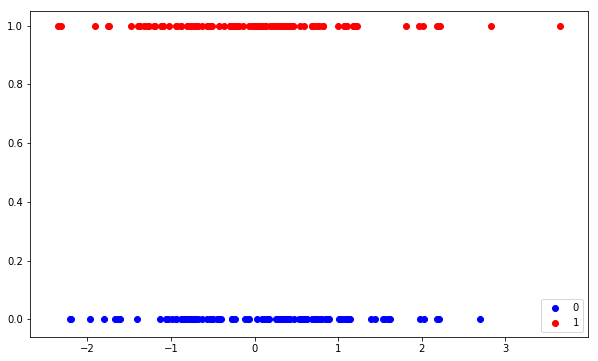

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 1], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 1], fake_y[fake_y == 1], color='r', label='1')
plt.legend();

You should be able to see that along the X-axis, the points are pretty separated around the boundary point X=0.3.  Along the Y-axis however there is not boundary point that separates the the points into 2 classes.

### Linear Regression with the X-component of our Fake Data

We've already learned about Linear Regression, so let's take a look at using linear regression to classify the data.  We'll use linear regression to choose a best fit (using the probability of being in our 1 and 0 classes as response variable regression values).  Then we'll classify all points for which the resultant model predicts a value above a certain threshold as belonging to class 1 and similarly we'll classify all points for which the resultant model predicts a value below a certain threshold as belonging to class 0.  Use sklearn's `LinearRegression` class to generate the linear regression model as described above.  Use only the X-component (the 0th component) of `fake_X` features as features in your linear regression model.  What's the appropriate threshold?

Exercise: Implement the linear regression model

In [186]:
fake_lr = LinearRegression()
fake_lr.fit(fake_X[:,0].reshape(-1,1), fake_y)
fake_lr_preds = fake_lr.predict(fake_X[:,0].reshape(-1,1 ))

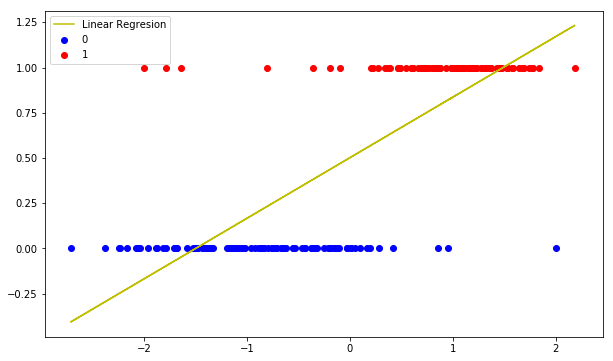

In [187]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(fake_X[:,0].reshape(-1,1), fake_lr_preds, color = 'y', label='Linear Regresion');
plt.legend();

All the problems mentioned in Lecture apply here.  Though we'd like our linear regression model to predict the probability that some our data points belong to a particular class, but for some of the data points this leads to non-interpretable values for class prediction probabilities.  In particular, our linear regression model predicts probabilities less than 0 and greater than 1 which is obviously problematic.  If we do use a threshold value to turn the predictions from our regression model into a class prediction, we can threshold at 0.5.  All data points for which our regression model predicts a value of less than 0.5 are classified as '0' and all other data points are classified as '1'.

### Logistic Regression with the X-component of our Fake Data

Let's use logistic regression to model the X-component of our fake data.  We'll start by examining what the logistic function looks like with various parameters overlaid on our data.

In [188]:
def sigmoid(x):
    '''Activation function used to map any real value between 0 and 1'''
    return 1 / (1 + np.exp(-x))

def sigmoid_prob(beta, x):
    '''Gives the probability after passing feature vector x through sigmoid of parameters beta'''
    return sigmoid(np.dot(x, beta))

def add_constant(x):
    '''Takes a feature vector x and adds a column of 1s'''
    return np.append(np.ones((x.shape[0],1)), x, axis=1)

Let's first start by generating 100 equally spaced points in our feature space (Let's call it from -3 to 2).  We'll use the trick we saw from linear regression of adding a column of ones to our data points so that we can apply the sigmoid to a dot product of our augmented data points and our beta parameters. 

In [189]:
data = np.linspace(-3,2,100).reshape(-1, 1)
augmented_data = add_constant(data)

Now let's plot the logistic function for the following 3 sets of beta parameters in which the first component $\beta_0$ varies.  How does varying $\beta_0$ affect the fit of the resulting logistic function?  Which of the three parameters is the best fit?

In [190]:
beta_1 = [.2, 10]
beta_2 = [-10, 10]
beta_3 = [10, 10]

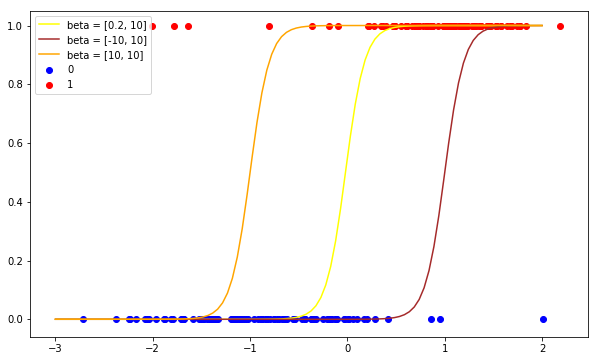

In [191]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(beta_1, augmented_data), color='yellow', label="beta = " + str(beta_1))
plt.plot(data, sigmoid_prob(beta_2, augmented_data), color='brown', label="beta = " + str(beta_2))
plt.plot(data, sigmoid_prob(beta_3, augmented_data), color='orange', label="beta = " + str(beta_3))
plt.legend();

Exercise: Now let's plot the logistic function for the following 3 sets of beta parameters in which the first component $\beta_0$ is the same as above but we've chosen a different fixed $\beta_1$ parameter.  How does varying $\beta_0$ affect the fit of the resulting logistic function?  Which of the three parameters is the best fit?

In [128]:
beta_1 = [.2, 6]
beta_2 = [-10, 6]
beta_3 = [10, 6]

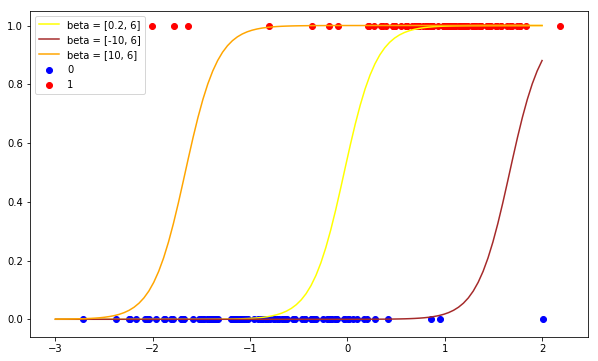

In [129]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(beta_1, augmented_data), color='yellow', label="beta = " + str(beta_1))
plt.plot(data, sigmoid_prob(beta_2, augmented_data), color='brown', label="beta = " + str(beta_2))
plt.plot(data, sigmoid_prob(beta_3, augmented_data), color='orange', label="beta = " + str(beta_3))
plt.legend();

Exercise: Now let's plot the logistic function for the following 3 sets of beta parameters in which the first component $\beta_0$ is the same as above but we've chosen a different fixed $\beta_1$ parameter.  How does varying $\beta_0$ affect the fit of the resulting logistic function?  Which of the three parameters is the best fit?

In [132]:
beta_1 = [.2, 20]
beta_2 = [-10,20]
beta_3 = [10, 20]

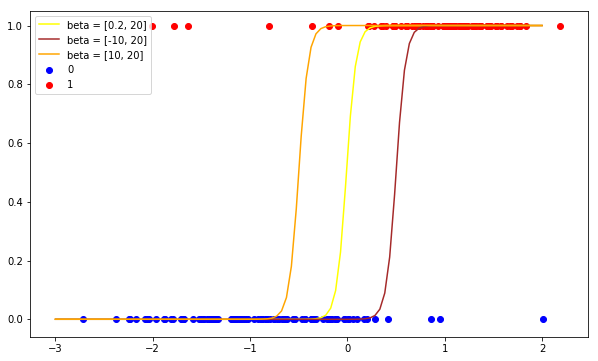

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(beta_1, augmented_data), color='yellow', label="beta = " + str(beta_1))
plt.plot(data, sigmoid_prob(beta_2, augmented_data), color='brown', label="beta = " + str(beta_2))
plt.plot(data, sigmoid_prob(beta_3, augmented_data), color='orange', label="beta = " + str(beta_3))
plt.legend();

**Discussion**:  Can you explain the changes in the logistic function for the experiments you tried above in terms of the log odds ratio as discussed in lecture?

Exercise: Now let's  plot the logistic function for the following 3 sets beta parameters in which the second parameter $\beta_1$ changes.  How does varying $\beta_1$ affect the fit of the resulting logistic functions.  Which of the three parameters is the best fit? 

In [134]:
beta_1 = [ -2, 1]
beta_2 = [ -2, 4]
beta_3 = [ -2, 10]

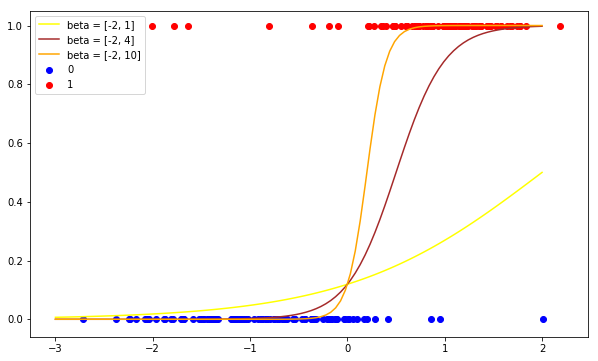

In [135]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(beta_1, augmented_data), color='yellow', label="beta = " + str(beta_1))
plt.plot(data, sigmoid_prob(beta_2, augmented_data), color='brown', label="beta = " + str(beta_2))
plt.plot(data, sigmoid_prob(beta_3, augmented_data), color='orange', label="beta = " + str(beta_3))
plt.legend();

### Solving Logistic Regression Manually with our Fake Data

As noted in lecture, finding the optimal solution for the logistic regression cost-function is non-trivial problem analytically.  Fortunately we can use approximate optimization methods.  Let's use the `minimize` function from scipy to calculate the optimal $\beta$ parameters.  First we'll construct a function to define our loss.

Exercise: Write a function `xent_loss`  that given beta coefficiients `beta`, a dataset `X` and binary labels `y` calculates the cross-entropy loss from using a logistic function with the given beta coefficients to classify the dataset `X`.

In [147]:
def xent_loss(beta, X, y):
    '''Computes the cross entropy loss for samples and labels given in X and y'''
    return -(1 / X.shape[0]) * np.sum(
        y * np.log(sigmoid_prob(beta, X)) + (1 - y) * np.log(
            1 - sigmoid_prob(beta, X)))


Now we'll use a lambda function to create a new function `fake_loss` that will apply our loss function to our fake dataset we created above.

In [148]:
fake_loss = lambda beta: xent_loss(beta, add_constant(fake_X[:,0].reshape(-1,1)), fake_y)

Now let's use the `minimize` function from scipy to find the optimal parameters

In [ ]:
opt_fake_params = minimize(fake_loss, beta_1, method="Nelder-Mead").x



Exercise: Plot the data overlayed on the logistic function from the manually calculated optimal parameters.  How well does the logistic function fit the data?

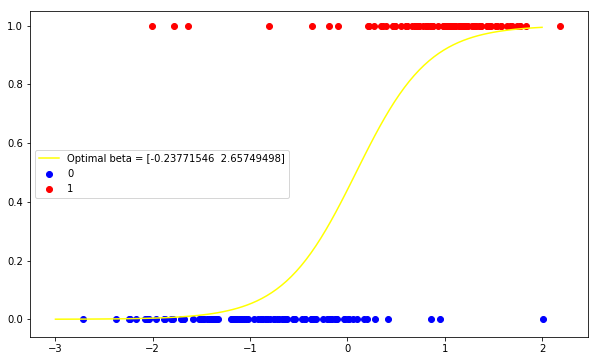

In [152]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(opt_fake_params, augmented_data), color='yellow', label="Optimal beta = " + str(opt_fake_params))
plt.legend();

### Solving Logistic Regression for our Fake Data with SKLearn

We can use sklearn to create a logistic regression model to directly calculate the optimal parameters.  Like the Linear Regression model, sklearn's logistic regression model is in its `linear_model` module.

Exercise: Use sklearn.linear_models.LogisticRegression to calculate the optimal parameters.  Plot the resulting logistic function overlayed on the data.  How do the parameters from sklearn compare to those from the manual calculation?

In [157]:
fake_lr = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
fake_lr.fit(fake_X[:,0].reshape(-1,1), fake_y)


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [169]:
lr_opt_fake_params = [fake_lr.intercept_[0], fake_lr.coef_[0][0]]

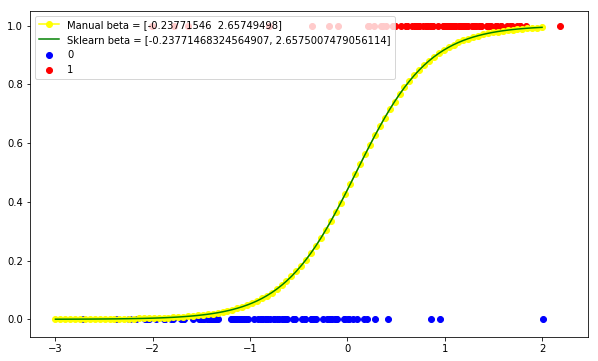

In [170]:
plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_y[fake_y == 0], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_y[fake_y == 1], color='r', label='1')
plt.plot(data, sigmoid_prob(opt_fake_params, augmented_data), color='yellow', marker='o', label="Manual beta = " + str(opt_fake_params))
plt.plot(data, sigmoid_prob(lr_opt_fake_params, augmented_data), color='green', label="Sklearn beta = " + str(lr_opt_fake_params))
plt.legend();

We should see great agreement between the two methods of calculating the Logistic Regession Parameters.

Let's use sklearn to calculate a logistic regression model for the entire fake dataset created (including both features).  What are the optimal parameters?

In [172]:
fake_lr2 = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
fake_lr2.fit(fake_X, fake_y)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [177]:
lr2_opt_params = list(fake_lr2.intercept_) + list(fake_lr2.coef_[0])
lr2_opt_params

[-0.258919403400393, 2.925811643766417, 0.6242667647204853]

Let's plot the decision boundary

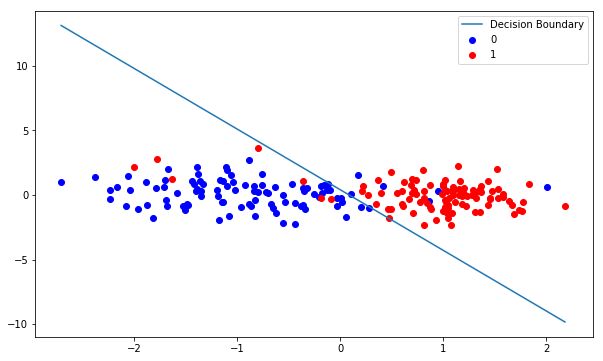

In [185]:
x_values = np.linspace(np.min(fake_X[:, 0]), np.max(fake_X[:, 0]), 200)
y_values = - (lr2_opt_params[0] + np.dot(lr2_opt_params[1], x_values)) / lr2_opt_params[2]

plt.figure(figsize=(10, 6))
plt.scatter(fake_X[fake_y == 0][:, 0], fake_X[fake_y == 0][:, 1], color='b', label='0')
plt.scatter(fake_X[fake_y == 1][:, 0], fake_X[fake_y == 1][:, 1], color='r', label='1')
plt.plot(x_values, y_values, label='Decision Boundary')

plt.legend();

#### Summary
- Logistic regression extends OLS to work naturally with a dependent variable that's only ever 0 and 1.
- In fact, Logistic regression is even more general and is used for predicting the probability of an example belonging to each of $N$ classes.
- The code for the two cases is identical and just like `LinearRegression`: `.fit`, `.score`, and all the rest
- Significant predictors does not imply that the model actually works well. Signifigance can be driven by data size alone.
- The data aren't enough to do what we want

**Warning**: Logistic regression _tries_ to hand back valid probabilities. As with all models, you can't trust the results until you validate them- if you're going to use raw probabilities instead of just predicted class, take the time to verify that if you pool all cases where the model says "I'm 30% confident it's class A" 30% of them actually are class A.